In [1]:
library(tidyverse)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'readr' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
data_dir <- file.path("..", "data")

In [3]:
tableone <- data.table::fread(file.path(data_dir, "tableone_raw.csv"), data.table = FALSE)
head(tableone)

,cov,ctrl.x,trtd.x,pval.x,smd.x,ctrl.y,trtd.y,smd.y,pval.y
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,n,3868,533,,NA,454,454,NA,NA
2,age,64.02 (15.15),64.77 (15.00),0.284,0.049,65.05 (16.14),65.10 (14.88),0.004,0.958
3,gender,52.1%,56.5%,0.066,0.087,55.1%,55.5%,0.009,0.945
4,weight,81.05 (22.06),80.41 (23.18),0.549,0.028,80.94 (24.83),80.70 (23.01),0.010,0.886
5,sapsii,36.61 (13.80),38.56 (14.32),0.003,0.139,39.48 (14.69),37.02 (13.48),0.175,0.006
6,sofa_24hours,3.68 (3.01),3.69 (2.97),0.942,0.003,3.83 (2.92),3.51 (2.93),0.109,0.102


In [4]:
tableone <- tableone %>%
dplyr::select(cov, pval.x, smd.x, pval.y, smd.y)

head(tableone)

,cov,pval.x,smd.x,pval.y,smd.y
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,n,,NA,NA,NA
2,age,0.284,0.049,0.958,0.004
3,gender,0.066,0.087,0.945,0.009
4,weight,0.549,0.028,0.886,0.010
5,sapsii,0.003,0.139,0.006,0.175
6,sofa_24hours,0.942,0.003,0.102,0.109


In [5]:
smd_tab <- tableone %>%
select(cov, smd.x, smd.y) %>%
gather("key", "value", smd.x, smd.y) %>%
filter(!is.na(value), value != "") %>%
mutate(value = gsub("<", "", value)) %>%
mutate(value = as.numeric(value))

str(smd_tab)

smd_tab <- tableone %>%
  dplyr::select(covariate = cov, smd.x, smd.y) %>%
  tidyr::gather("key", "value", smd.x, smd.y) %>%
  dplyr::filter(!is.na(value) & value != "") %>%
  dplyr::mutate(value = gsub("<", "", value)) %>%
  dplyr::mutate(value = as.numeric(value))

'data.frame':	55 obs. of  3 variables:
 $ cov  : chr  "age" "gender" "weight" "sapsii" ...
 $ key  : chr  "smd.x" "smd.x" "smd.x" "smd.x" ...
 $ value: num  0.049 0.087 0.028 0.139 0.003 0.072 0.081 0.049 0.029 0.178 ...


注意数据的格式，可以打印出来看一下数据集，head(tableone)

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."


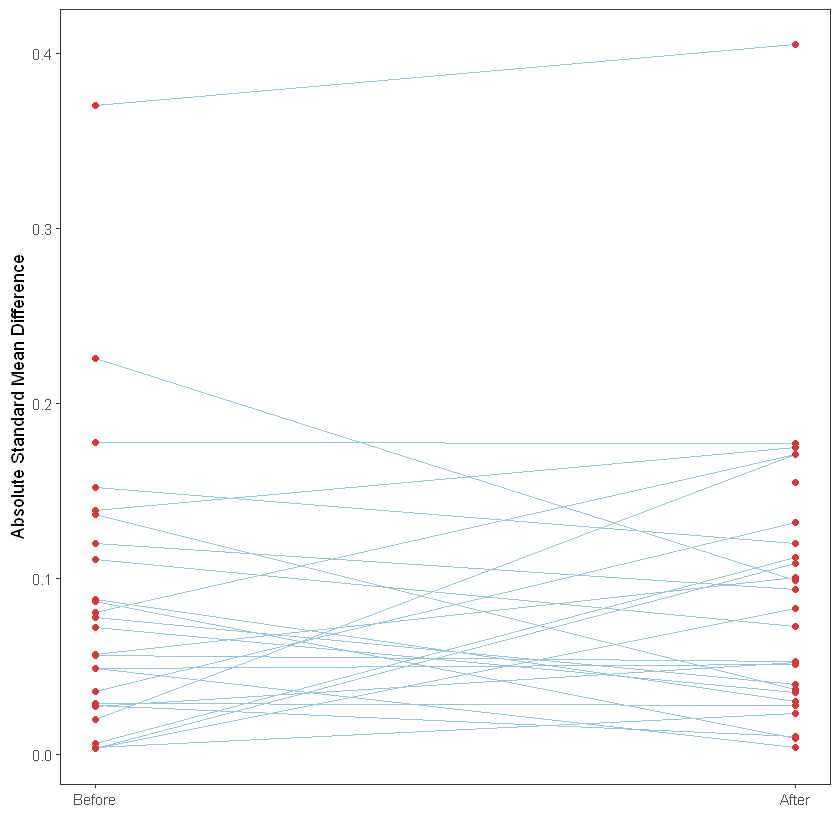

In [6]:
ggplot() +
geom_segment(data = smd_tab %>% spread(key, value),
             aes(x = 0, y = smd.x, xend = 1, yend = smd.y), color = "#92c5de") +
geom_point(data = smd_tab %>%
           mutate(key = case_when(
               key == "smd.x" ~ 0L,
               key == "smd.y" ~ 1L
           )), aes(x = key, y = value), color = "#dc3535") +
scale_x_continuous(breaks = c(0, 1), labels = c("Before", "After")) +
labs(x = "", y = "Absolute Standard Mean Difference") +
theme_bw() +
theme(panel.grid = element_blank())

In [7]:
pval_tab <- tableone %>%
dplyr::select(cov, pval.x, pval.y) %>%
rename(x = pval.x, y = pval.y) %>% 
gather("key", "value", x, y) %>%
filter(!is.na(value), value != "") %>%
mutate(value = gsub("<", "", value)) %>%
mutate(value = as.numeric(value)) %>%
spread(key, value) %>%
mutate(rx = rank(x, ties.method = "first"), ry = rank(y, ties.method = "first"))

pval_tab <- pval_tab %>%
dplyr::select(rx, x) %>%
rename(r = rx) %>%
full_join(pval_tab %>%
         dplyr:: select(ry, y) %>%
          rename(r = ry), by = "r") %>%
arrange(r) %>%
gather("key", "value", x, y)

head(pval_tab)

,r,key,value
,<int>,<chr>,<dbl>
1,1,x,0.001
2,2,x,0.001
3,3,x,0.001
4,4,x,0.001
5,5,x,0.003
6,6,x,0.009


,r,key,value
,<int>,<chr>,<dbl>
1,1,x,0.001
2,2,x,0.001
3,3,x,0.001
4,4,x,0.001
5,5,x,0.003
6,6,x,0.009


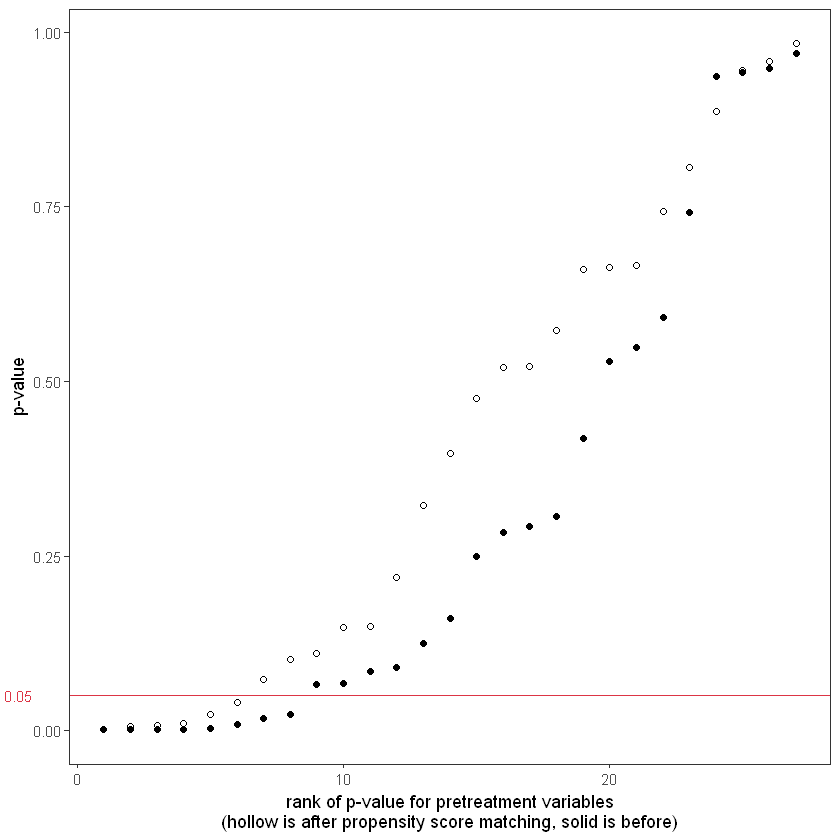

In [8]:
pval_tab <- tableone %>%
dplyr::select(cov, pval.x, pval.y) %>%
rename(x = pval.x, y = pval.y) %>% 
gather("key", "value", x, y) %>%
filter(!is.na(value), value != "") %>%
mutate(value = gsub("<", "", value)) %>%
mutate(value = as.numeric(value)) %>%
spread(key, value) %>%
mutate(rx = rank(x, ties.method = "first"), ry = rank(y, ties.method = "first"))

pval_tab <- pval_tab %>%
dplyr::select(rx, x) %>%
rename(r = rx) %>%
full_join(pval_tab %>%
         dplyr:: select(ry, y) %>%
          rename(r = ry), by = "r") %>%
arrange(r) %>%
gather("key", "value", x, y)

head(pval_tab)




p <- ggplot() +
geom_point(data = pval_tab, aes(x = r, y = value, shape = key), show.legend = FALSE) +
geom_hline(yintercept = 0.05, color = "#dc3545") +
scale_shape_manual(values = c(19, 1)) +
annotation_custom(grid::textGrob("0.05",
                                 gp = grid::gpar(col = "#dc3545", fontsize = 9.1)), 
        xmin = -2.2, xmax = -2.2, ymin = 0.05, ymax = 0.05) +
labs(y = "p-value",
     x = "rank of p-value for pretreatment variables\n(hollow is after propensity score matching, solid is before)") +
theme_bw() +
theme(panel.grid = element_blank())

g <- ggplotGrob(p)
g$layout$clip[g$layout$name=="panel"] <- "off"
grid::grid.draw(g)